# Civil Engineering Machine Learning Project
## Damage evaluation of reinforced concrete beams with varying thickness using the acoustic emission technique


***
## 1. Data Extraction

In [64]:
"""
Created on Tue Jul 18 03:12:39 2017

@author: Aamir
"""
%matplotlib inline

### Import Libraries

In [109]:

import os
import scipy.io
import numpy as np
import pandas as pd

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

from IPython.display import SVG
import matplotlib.pyplot as plt

In [66]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Import and select relevant data 

In [67]:
data = pd.read_excel("concrete-damage-data.xlsx")
data = data.iloc[:,[4, 5, 6, 7, 8, 9, 10, 17, 18, 19]]
data = data.dropna()
data.reset_index(drop=True,inplace=True)

### Check data frame structure 

In [68]:
data.shape

(82873, 10)

In [69]:
data.dtypes

CH              object
RISE            object
COUN            object
ENER            object
DURATION        object
AMP             object
A_FRQ           object
SIG_STRNGTH     object
ABS_ENERGY      object
DAMAGE         float64
dtype: object

In [70]:
data.head()

,CH,RISE,COUN,ENER,DURATION,AMP,A_FRQ,SIG_STRNGTH,ABS_ENERGY,DAMAGE
0,4,9,5,2,114,52,44,14372,260.846,0.0
1,3,1,1,0,1,45,1000,115.9,2.124,0.0
2,3,23,3,1,69,48,43,7241,107.876,0.0
3,4,1,2,1,79,46,25,7024,85.976,0.0
4,3,22,3,1,86,48,35,9022,133.646,0.0


***
## 2. Data Cleaning
### Check and fill missing values 

In [71]:
data.count()

CH             82873
RISE           82873
COUN           82873
ENER           82873
DURATION       82873
AMP            82873
A_FRQ          82873
SIG_STRNGTH    82873
ABS_ENERGY     82873
DAMAGE         82873
dtype: int64

No missing data. Incomplete entries have already been removed.

### Convert to numeric columns 

In [72]:
data['CH'] = data['CH'].astype(int)
data['RISE'] = data['RISE'].astype(int)
data['COUN'] = data['COUN'].astype(int)
data['ENER'] = data['ENER'].astype(int)
data['DURATION'] = data['DURATION'].astype(int)
data['AMP'] = data['AMP'].astype(int)
data['A_FRQ'] = data['A_FRQ'].astype(int)
data['SIG_STRNGTH'] = data['SIG_STRNGTH'].astype(float)
data['ABS_ENERGY'] = data['ABS_ENERGY'].astype(float)
data['DAMAGE'] = data['DAMAGE'].astype(int)

data.dtypes

CH               int32
RISE             int32
COUN             int32
ENER             int32
DURATION         int32
AMP              int32
A_FRQ            int32
SIG_STRNGTH    float64
ABS_ENERGY     float64
DAMAGE           int32
dtype: object

In [73]:
# data.to_excel("Aamirdata.xlsx")

### Normalize Data

In [74]:
# mn = pd.DataFrame.mean(data)
# vr = pd.DataFrame.var(data)

# data.RISE = (data.RISE - mn.RISE) / vr.RISE
# data.COUN = (data.COUN - mn.COUN) / vr.COUN
# data.ENER = (data.ENER - mn.ENER) / vr.ENER
# data.DURATION = (data.DURATION - mn.DURATION) / vr.DURATION
# data.AMP = (data.AMP - mn.AMP) / vr.AMP
# data.A_FRQ = (data.A_FRQ - mn.A_FRQ) / vr.A_FRQ
# data.SIG_STRNGTH = (data.SIG_STRNGTH - mn.SIG_STRNGTH) / vr.SIG_STRNGTH
# data.ABS_ENERGY = (data.ABS_ENERGY - mn.ABS_ENERGY) / vr.ABS_ENERGY

In [75]:
#X = np.array(data.iloc[:,0:9])
X = data.iloc[:,0:9]
y = data['DAMAGE']

Split Train/Test Sets

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [88]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66298, 9), (16575, 9), (66298,), (16575,))

***
## 3. Train and Evaluate the Model

### XGBoost MODEL

### XGBoost Setup

In [90]:
# Specify the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost training and evaluation

In [91]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.9, 'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:1.79598	valid-rmse:1.80237
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.63583	valid-rmse:1.64219
[2]	train-rmse:1.49338	valid-rmse:1.49979
[3]	train-rmse:1.36725	valid-rmse:1.37377
[4]	train-rmse:1.25553	valid-rmse:1.2623
[5]	train-rmse:1.15719	valid-rmse:1.1641
[6]	train-rmse:1.07079	valid-rmse:1.07794
[7]	train-rmse:0.995138	valid-rmse:1.00272
[8]	train-rmse:0.929053	valid-rmse:0.937335
[9]	train-rmse:0.871763	valid-rmse:0.880426
[10]	train-rmse:0.82244	valid-rmse:0.831516
[11]	train-rmse:0.779888	valid-rmse:0.789517
[12]	train-rmse:0.743719	valid-rmse:0.753842
[13]	train-rmse:0.712978	valid-rmse:0.723628
[14]	train-rmse:0.68665	valid-rmse:0.697974
[15]	train-rmse:0.664298	valid-rmse:0.676505
[16]	train-rmse:0.645711	valid-rmse:0.658518
[17]	train-rmse:0.630026	valid-rmse:0.643443
[18]	train-rmse:0.617101	valid-rmse:0.630893
[19]	train-rmse:0.606535	vali

In [104]:
print(model)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Train/Validation Set Evaluation 

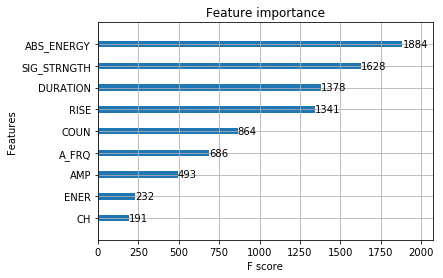

In [92]:
xgb.plot_importance(model, height=0.3)

### Prediction

In [93]:
# evaluate the model
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [94]:
pred

array([ 10.17860794,   9.59091282,   9.64553165, ...,   9.9689846 ,
        10.10915089,  10.32638264], dtype=float32)

In [114]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [115]:
# make predictions for test data
y_pred = model.predict(X_valid)
predictions = [round(value) for value in y_pred]

In [116]:
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.63%


### RandomTreeClassifier MODEL

### Check feature importance

In [95]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X,y)

In [97]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

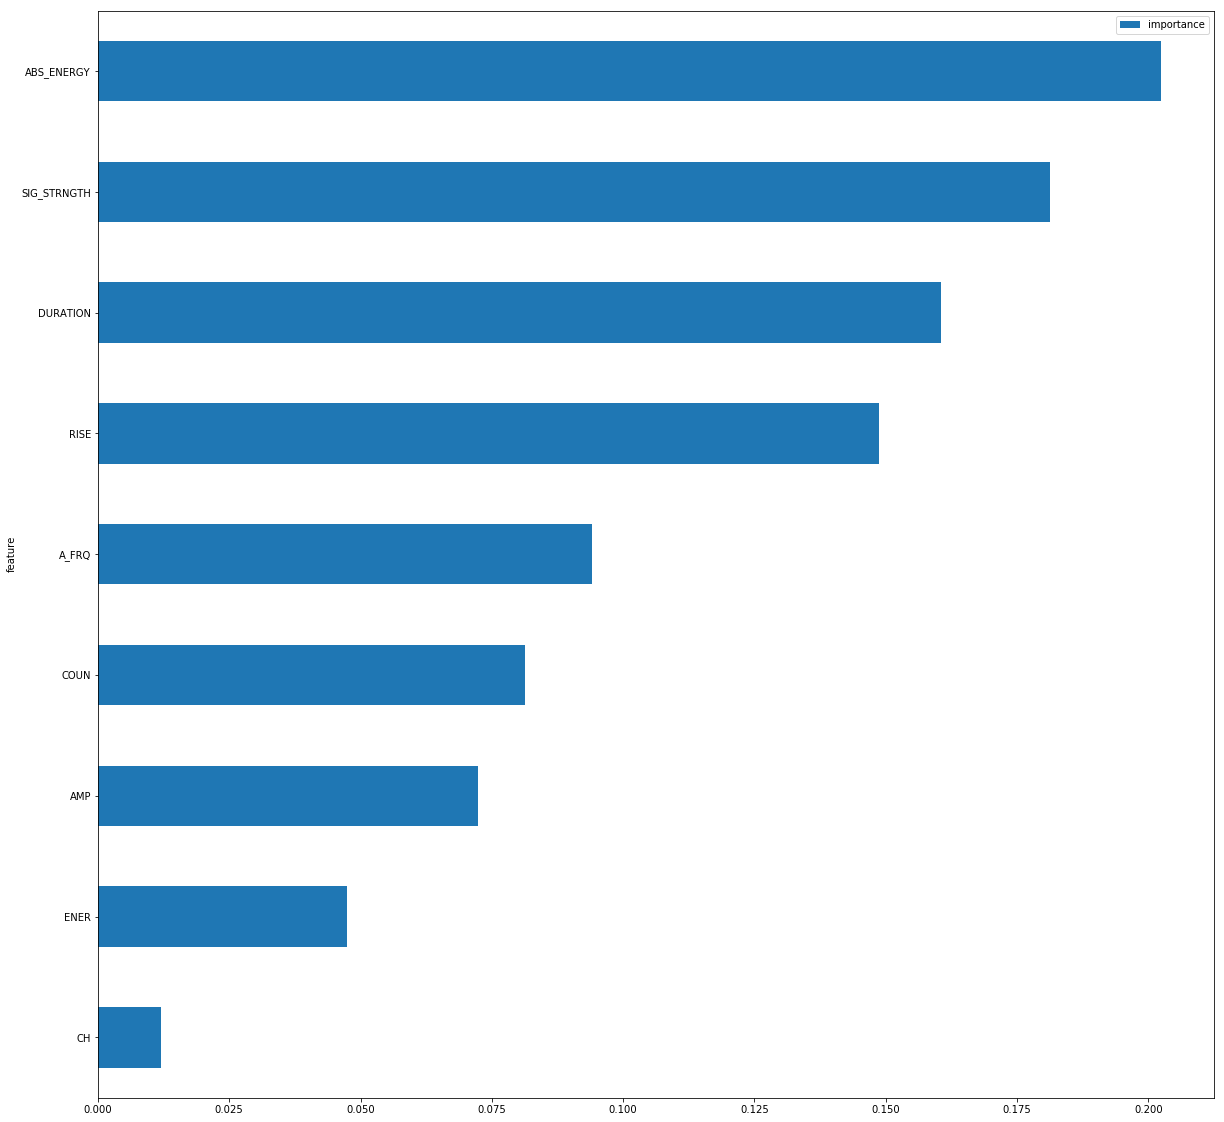

In [98]:
features.plot(kind='barh', figsize=(20, 20))

### Hyperparameter tuning

In [100]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model = RandomForestClassifier(**parameters)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [103]:
xval = cross_val_score(model, X_valid, y_valid, cv = 5, scoring='accuracy')
np.mean(xval)

0.55837236004412993

***
## 5. Predict the Test set

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [ ]:
my_solution.index.name

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline